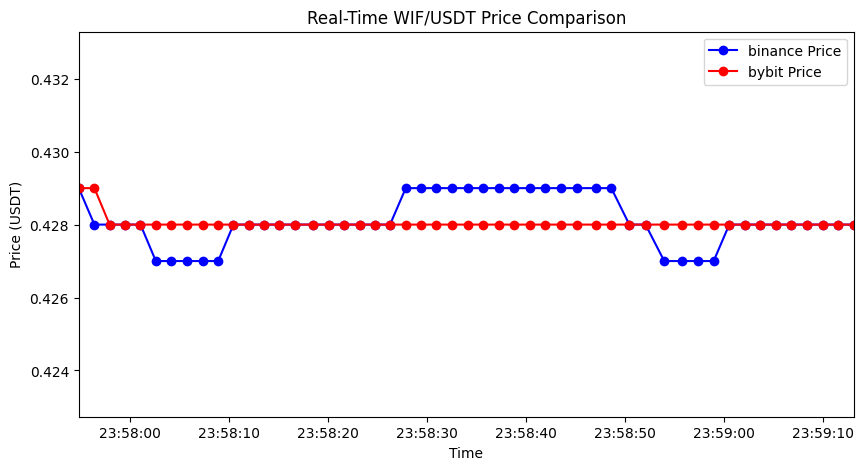

In [ ]:
import asyncio
import ccxt.async_support as ccxt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime
import pandas as pd
import nest_asyncio
from IPython.display import display, clear_output

# Enable nested asyncio to avoid Jupyter event loop conflicts
nest_asyncio.apply()

# Set exchange names and symbol
EXCHANGE_1_NAME = "binance"
EXCHANGE_2_NAME = "bybit"
SYMBOL = "WIF/USDT"

# Initialize exchanges
exchange_1 = getattr(ccxt, EXCHANGE_1_NAME)({"enableRateLimit": True})
exchange_2 = getattr(ccxt, EXCHANGE_2_NAME)({"enableRateLimit": True})

# Store historical prices
data = {"time": [], "price_1": [], "price_2": []}

async def fetch_price(exchange, symbol):
    """Fetch the latest price of a given symbol from an exchange."""
    try:
        ticker = await exchange.fetch_ticker(symbol)
        return ticker["last"]
    except Exception as e:
        print(f"⚠️ Error fetching {symbol} from {exchange.id}: {e}")
        return None

async def update_prices():
    """Continuously fetch prices and update the plot in Jupyter Notebook."""
    
    # Set up the figure
    fig, ax = plt.subplots(figsize=(10, 5))

    while True:
        try:
            price_1 = await fetch_price(exchange_1, SYMBOL)
            price_2 = await fetch_price(exchange_2, SYMBOL)
            current_time = datetime.datetime.now()

            if price_1 and price_2:
                data["time"].append(current_time)
                data["price_1"].append(price_1)
                data["price_2"].append(price_2)

                # Keep only the last 50 data points
                if len(data["time"]) > 50:
                    for key in data:
                        data[key] = data[key][-50:]

                # Clear previous output and update plot
                clear_output(wait=True)
                ax.clear()
                
                # Plot updated data
                ax.plot(data["time"], data["price_1"], "bo-", label=f"{EXCHANGE_1_NAME} Price")  # Binance
                ax.plot(data["time"], data["price_2"], "ro-", label=f"{EXCHANGE_2_NAME} Price")  # Bybit

                # Format the plot
                ax.set_title(f"Real-Time {SYMBOL} Price Comparison")
                ax.set_xlabel("Time")
                ax.set_ylabel("Price (USDT)")
                ax.legend()
                ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M:%S"))
                ax.set_xlim(min(data["time"]), max(data["time"]))
                ax.set_ylim(min(min(data["price_1"]), min(data["price_2"])) * 0.99, 
                            max(max(data["price_1"]), max(data["price_2"])) * 1.01)

                # Show the updated plot
                display(fig)
                plt.pause(1)  # Update every second

        except Exception as e:
            print(f"⚠️ Error updating prices: {e}")

async def main():
    """Run the price update function asynchronously."""
    await update_prices()

# Run the async loop in Jupyter
await main()
